Importing the necessary library files

In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image

Loading TransCG Dataset from Google Drive

In [2]:
path_to_dataset = "drive//MyDrive//M202A//transcg//"

config={"path":path_to_dataset,"all_files":[]}
def extract_files(config):
  path = config["path"]
  all_files = config["all_files"]
  for (path,directory,files) in tqdm(os.walk(path)):
    if(files!=[]):
      files= [path+"//"+i for i in files]
      if((path+"//rgb2.png" in files) and(path+"//depth2-gt.png" in files) and (path+"//depth2-gt-mask.png") and (path+"//depth2.png" in files)):
          all_files.append(files)


extract_files(config)


1921it [01:44, 18.36it/s]


In [3]:
len(config["all_files"])
print(config["all_files"][0])

['drive//MyDrive//M202A//transcg//scene12/95//rgb2.png', 'drive//MyDrive//M202A//transcg//scene12/95//depth2-gt.png', 'drive//MyDrive//M202A//transcg//scene12/95//depth2-gt-sn.png', 'drive//MyDrive//M202A//transcg//scene12/95//depth2.png', 'drive//MyDrive//M202A//transcg//scene12/95//depth2-gt-mask.png']


In [4]:
def load_files(config):
  filepaths = config["all_files"]
  length = len(filepaths)
  batchsize = length//6
  indices = np.random.randint(low=0,high=length,size=batchsize)
  color = np.zeros((batchsize,1280,720,3)).astype(np.uint8)
  rawdepth = np.zeros((batchsize,1280,720)).astype(np.float32)
  groundtruth = np.zeros_like(rawdepth).astype(np.float32)
  depthmasks = np.zeros_like(rawdepth).astype(np.uint8)
  pbar = tqdm(total=batchsize)
  count = 0
  for idx in indices:
    files = filepaths[idx]
    for f in files:
      if("rgb2.png" in f):
        color[count,...] = np.asarray(Image.open(f)).transpose(1,0,2)
      elif("depth2-gt-mask.png" in f):
        depthmasks[count,...] = np.asarray(Image.open(f)).astype(np.uint8).T
      elif("depth2-gt.png" in f):
        rawdepth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
      elif("depth2.png" in f):
        groundtruth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
    pbar.update(1)
    count+=1
  config["color"] = color
  config["depth"] = groundtruth
  config["rawDepth"] = rawdepth
  config["validmasks"]= depthmasks

load_files(config)

100%|██████████| 318/318 [07:39<00:00,  1.44s/it]


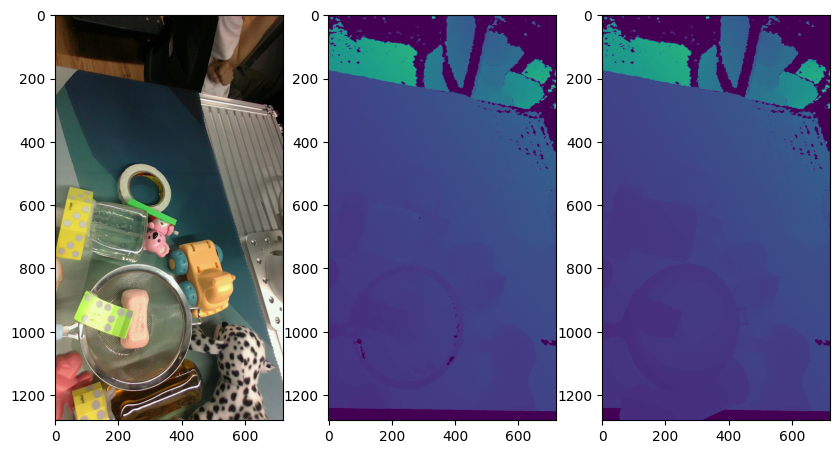

In [5]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0])

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])



Perform Bilateral Filtering

In [6]:
length = len(color)
error = []

denoised_depth_images = np.zeros_like(rawdepth)
for i in tqdm(range(length)):
  denoised_depth_images[i,...] = cv2.bilateralFilter(rawdepth[i]*2.5e-4,5,150,150)
  validity_mask = rawdepth[i]>0
  error.append((depth[i][validity_mask]*2.5e-4-denoised_depth_images[i][validity_mask]))


100%|██████████| 318/318 [00:07<00:00, 41.16it/s]


Measure the MAE, RMSE

Average MAE is  22.303108125925064
Average root mean squared error is  86.6178348660469


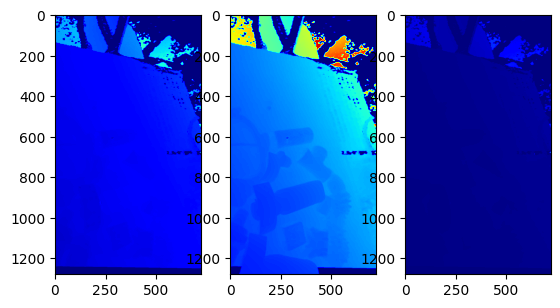

In [7]:
mae = [np.mean(abs(i)) for i in error]
rmse = [np.sqrt(np.mean(i**2)) for i in error]
print("Average MAE is ",np.mean(mae)*1000)
print("Average root mean squared error is ",np.mean(rmse)*1000)

random_indice = np.random.randint(low=0,high = len(mae))
denoised_image = denoised_depth_images[random_indice]
mean_squared_error = (depth[random_indice] - denoised_image)**2
fig,axs = plt.subplots(1,3)
axs[0].imshow(depth[random_indice],cmap="jet")
axs[1].imshow(denoised_image,cmap="jet")
axs[2].imshow(mean_squared_error,cmap='jet')

(-0.5, 719.5, 1279.5, -0.5)

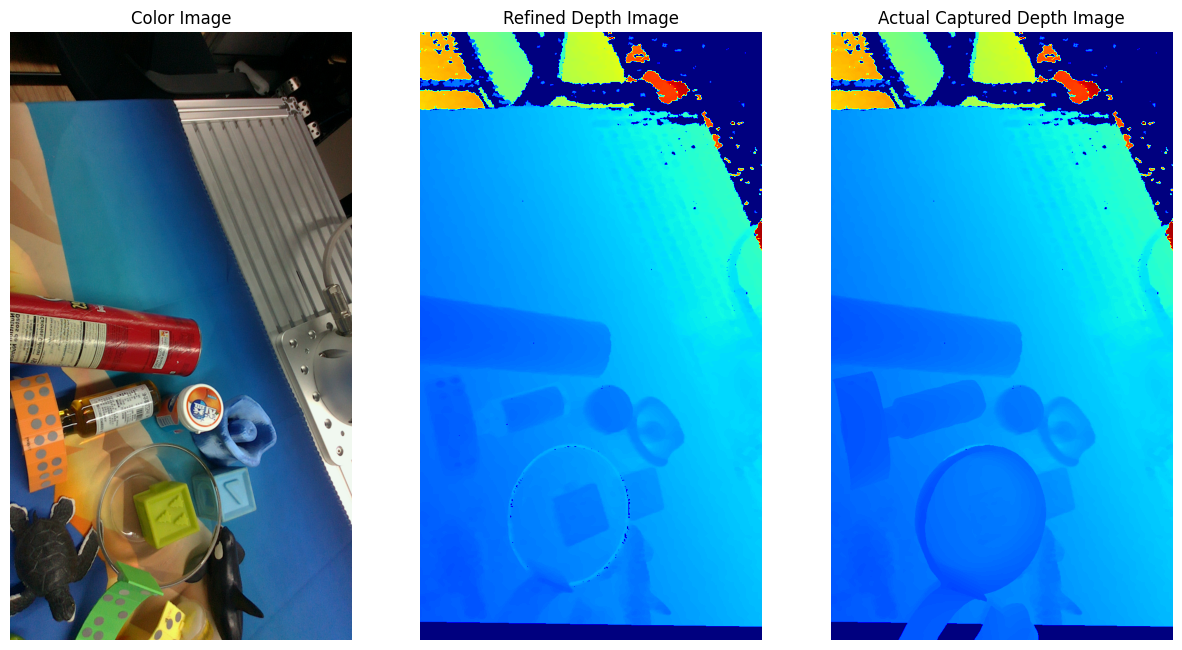

In [8]:
random_indice = np.random.randint(low=0,high = len(mae))
fig,axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(color[random_indice].astype(np.uint8))
axs[0].set_title("Color Image")
axs[0].axis("off")
axs[1].imshow(depth[random_indice],cmap="jet")
axs[1].axis("off")
axs[1].set_title("Refined Depth Image")
axs[2].imshow(rawdepth[random_indice],cmap="jet")
axs[2].set_title("Actual Captured Depth Image")
axs[2].axis("off")